In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import scipy
import seaborn as sns; sns.set()
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
print("\nLoading data...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
labels = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]
x_train = x_train/255.0
x_test = x_test/255.0
y_train = y_train.flatten()
y_test = y_test.flatten()
print(x_train.shape, y_train.shape, x_train.dtype, y_train.dtype)
print(x_test.shape, y_test.shape, x_test.dtype, y_test.dtype)


Loading data...
(50000, 32, 32, 3) (50000,) float64 uint8
(10000, 32, 32, 3) (10000,) float64 uint8


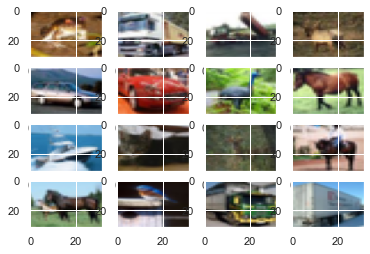

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9508811927902190056
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4147576832
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9965740394478716239
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:2d:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [4]:

fig, ax = plt.subplots(4, 4)
k = 0
 
for i in range(4):
    for j in range(4):
        ax[i][j].imshow(x_train[k], aspect='auto')
        k += 1
 
plt.show()
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [5]:
num_classes = 10

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=x_train[0].shape))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D((2,2)))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D((2,2)))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D((2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=1024, activation='relu'))
#model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=10, activation = 'softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=optimizer,
              metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                              mode='max', 
                                              patience=5, 
                                              verbose=1)
model_save = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', 
                                                monitor='accuracy', 
                                                save_best_only=True)

data_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
                                                          height_shift_range=0.1,
                                                          horizontal_flip = True)
train_gen = data_gen.flow(x_train, y_train, 32)
spe = x_train.shape[0] // 32
history = model.fit(train_gen, 
                    epochs=50, 
                    callbacks=[early_stop, model_save],
                    steps_per_epoch=spe,
                    verbose=1,
                    validation_data=(x_test, y_test))


Epoch 1/50
1562/1562 [==============================] - 28s 12ms/step - loss: 1.4349 - accuracy: 0.5039 - val_loss: 0.9911 - val_accuracy: 0.6479
Epoch 2/50
1562/1562 [==============================] - 18s 12ms/step - loss: 1.0025 - accuracy: 0.6490 - val_loss: 0.8197 - val_accuracy: 0.7177
Epoch 3/50
1562/1562 [==============================] - 17s 11ms/step - loss: 0.8508 - accuracy: 0.7048 - val_loss: 0.7924 - val_accuracy: 0.7315
Epoch 4/50
1562/1562 [==============================] - 18s 11ms/step - loss: 0.7622 - accuracy: 0.7391 - val_loss: 0.7791 - val_accuracy: 0.7397
Epoch 5/50
1562/1562 [==============================] - 18s 12ms/step - loss: 0.6913 - accuracy: 0.7635 - val_loss: 0.7531 - val_accuracy: 0.7589
Epoch 6/50
1562/1562 [==============================] - 17s 11ms/step - loss: 0.6397 - accuracy: 0.7846 - val_loss: 0.6280 - val_accuracy: 0.7909
Epoch 7/50
1562/1562 [==============================] - 18s 11ms/step - loss: 0.5960 - accuracy: 0.7979 - val_loss: 0.5730 -

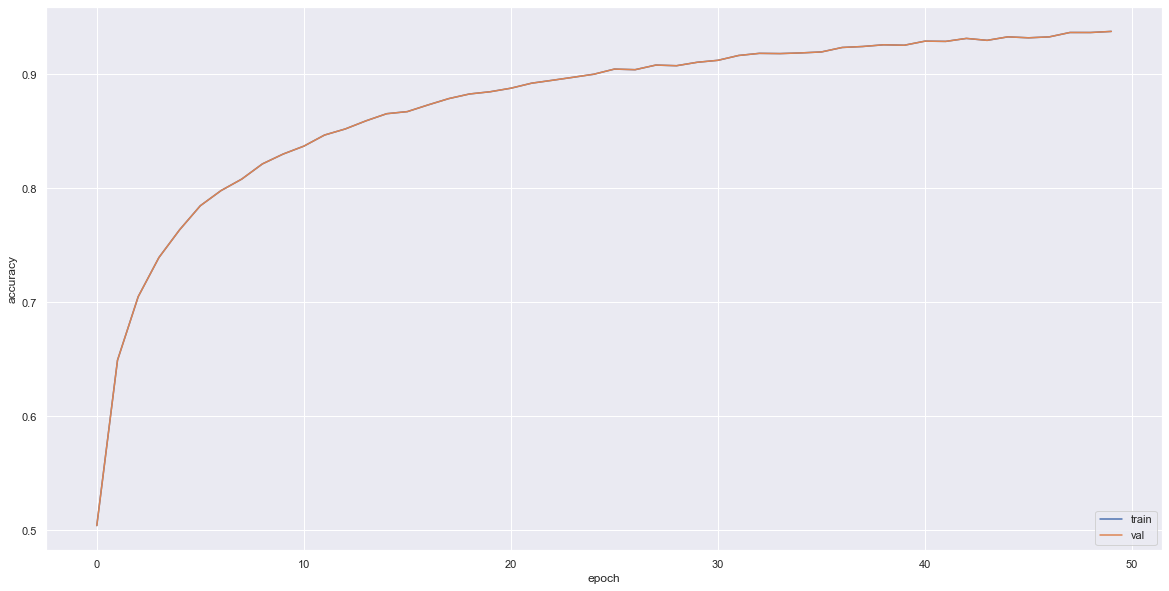

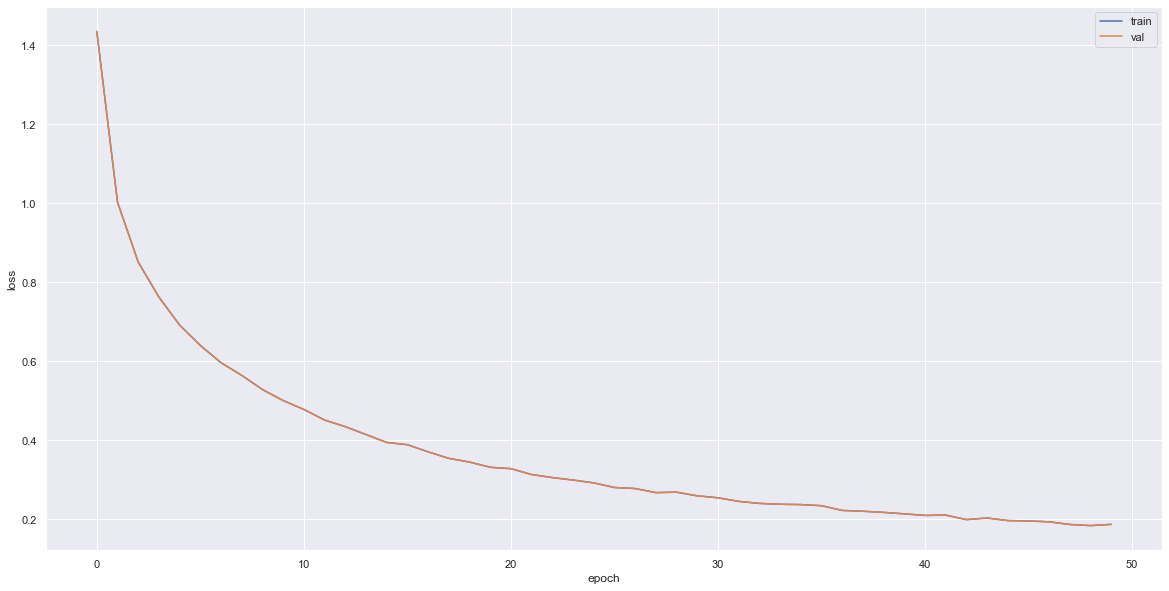

In [7]:
plt.rcParams["figure.figsize"] = (20,10)

# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# loss
plt.plot(history.history['loss'])
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


In [8]:
# restore weights from the best training point
model.load_weights('best_model.h5')

scores = model.evaluate(x_train, y_train, verbose=0)
print('TRAINING SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x_test, y_test, verbose=0)
print('\nTEST SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

TRAINING SET
Loss: 0.10005547851324081 
Accuracy: 0.9667199850082397

TEST SET
Loss: 0.41521909832954407 
Accuracy: 0.879800021648407


In [9]:
t = [0,1,2,3,4,5,6,7,8,9]
y_pred = np.argmax(model.predict(x_test), axis=1)

313/313 [==============================] - 1s 2ms/step


Text(442.70000000000005, 0.5, 'pred label')

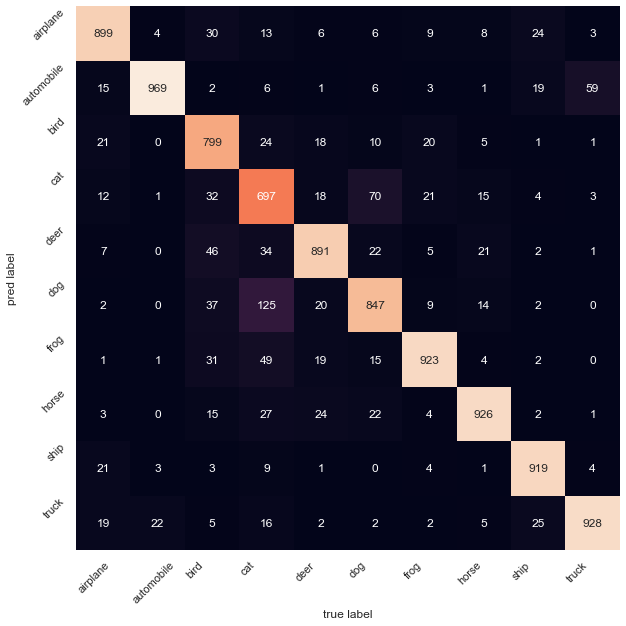

In [10]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)
plt.xticks(ticks=t,labels=labels, rotation=45, ha='left')
plt.yticks(ticks=t, labels=labels, rotation=45,  va='top')
plt.xlabel('true label')
plt.ylabel('pred label')